In [312]:
#!/usr/bin/env python3
import pickle as pk
import sys
import time as tm
from argparse import ArgumentParser
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import scipy as sc
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from captum.attr import FeatureAblation
from sklearn.metrics import mean_squared_error, r2_score
from torch.utils.data.dataset import Dataset

sns.set_theme()

In [313]:
class dataset_geno(Dataset):
    """a class for importing simulated genotype-phenotype data.
    It expects a pickled object that is organized as a list of tensors:
    genotypes[n_animals, n_loci, n_alleles] (one hot at allelic state)
    gen_locs[n_animals, n_loci] (index of allelic state)
    weights[n_phens, n_loci, n_alleles] float weight for allelic contribution to phen
    phens[n_animals,n_phens] float value for phenotype
    indexes_of_loci_influencing_phen[n_phens,n_loci_ip] integer indicies of loci that influence a phenotype
    interaction_matrix[FILL THIS IN]
    pleiotropy_matrix[n_phens, n_phens, gen_index]"""

    def __init__(self, data_file, n_geno):
        self.datset = pk.load(open(data_file, "rb"))
        self.genotypes = torch.tensor(np.array(self.datset["genotypes"]), dtype=torch.float32)
        self.data_file = data_file
        self.n_geno = n_geno

    def __len__(self):
        return len(self.genotypes)

    def __getitem__(self, idx):
        genotypes = torch.flatten(self.genotypes[idx])
        return genotypes

In [314]:
train_data_geno = dataset_geno('sim_2trait_dec18_train.pk', n_geno=4297)
test_data_geno = dataset_geno('sim_2trait_dec18_test.pk', n_geno=4297)


In [315]:
n_geno = 4297
n_alleles = 2
latent_space_g = 10000

In [316]:
print(test_data_geno[0])
len(test_data_geno)
len(test_data_geno[0])

tensor([1., 0., 1.,  ..., 0., 0., 1.])


8594

In [317]:
test_loader_geno = torch.utils.data.DataLoader(
    dataset=test_data_geno, batch_size=10, num_workers=1, shuffle=True
)


train_loader_geno = torch.utils.data.DataLoader(
    dataset=train_data_geno, batch_size=10, num_workers=1, shuffle=True
)


# define encoder/decoder architecture

In [318]:
# gencoder
class GQ_net(nn.Module):
    def __init__(self, n_loci=None, N=None):
        super().__init__()
        if N is None:
            N = latent_space_g
        if n_loci is None:
            n_loci = n_geno * n_alleles

        batchnorm_momentum = 0.8
        g_latent_dim = latent_space_g
        self.encoder = nn.Sequential(
            nn.Linear(in_features=n_loci, out_features=N),
            nn.BatchNorm1d(N, momentum=0.8),
            nn.LeakyReLU(0.01),
            nn.Linear(in_features=N, out_features=g_latent_dim),
            nn.BatchNorm1d(g_latent_dim, momentum=0.8),
            nn.LeakyReLU(0.01),
        )

    def forward(self, x):
        x = self.encoder(x)
        return x


# gendecoder
class GP_net(nn.Module):
    def __init__(self, n_loci=None, N=None):
        super().__init__()
        if N is None:
            N = latent_space_g
        if n_loci is None:
            n_loci = n_geno * n_alleles

        batchnorm_momentum = 0.8
        g_latent_dim = latent_space_g
        self.encoder = nn.Sequential(
            nn.Linear(in_features=g_latent_dim, out_features=N),
            nn.BatchNorm1d(N, momentum=batchnorm_momentum),
            nn.LeakyReLU(0.01),
            nn.Linear(in_features=N, out_features=n_loci),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        return x


In [319]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

GQ = GQ_net()
GP = GP_net()

GQ.to(device)
GP.to(device)

EPS = 1e-15
reg_lr = 0.001
adam_b = (0.5, 0.999)

optim_GQ_enc = torch.optim.Adam(GQ.parameters(), lr=reg_lr, betas=adam_b)
optim_GP_dec = torch.optim.Adam(GP.parameters(), lr=reg_lr, betas=adam_b)


cuda


In [320]:
in_genos = pk.load(open('sim_2trait_dec18.pk','rb'))
in_genos = in_genos['genotypes']

# Convert to a PyTorch tensor
tensor = torch.tensor(in_genos)

# Sum across the first axis
summed_tensor = tensor.sum(dim=0)

# Flatten the summed tensor
pop_freqs = summed_tensor.flatten()

#calculated allele weights based on abundance
allele_weights = (3000-pop_freqs+EPS)/((pop_freqs+EPS)) #calculate relative allele freq of 1's in batch
allele_weights = allele_weights.to(device)

In [321]:
print(allele_weights)
print(pop_freqs)

tensor([1.0010e-03, 9.9900e+02, 5.0420e-02,  ..., 1.1245e+01, 1.2762e+00,
        7.8359e-01], device='cuda:0')
tensor([2997,    3, 2856,  ...,  245, 1318, 1682])


In [322]:

# train genetic autoencoder
g_rcon_loss = []

num_epochs_gen = 3

start_time = tm.time()

gen_noise = 1 - 0.3

for n in range(num_epochs_gen):
    for i, (gens) in enumerate(train_loader_geno):
        batch_size = gens.shape[0]  # redefine batch size here to allow for incomplete batches

        # reconstruction loss
        GP.zero_grad()
        GQ.zero_grad()

        gens = gens[:, : n_geno*n_alleles]

        pos_noise = np.random.binomial(1, gen_noise / 2, gens.shape)

        neg_noise = np.random.binomial(1, gen_noise / 2, gens.shape)

        noise_gens = torch.tensor(
            np.where((gens + pos_noise - neg_noise) > 0, 1, 0), dtype=torch.float32
        )

        noise_gens = noise_gens.to(device)

        gens = gens.to(device)

        #batch_allele_freq = (1-gens.mean(dim=0)+EPS)/((gens.mean(dim=0)+EPS)) #calculate relative allele freq of 1's in batch

        weights = torch.where(  #checks where input g tensor =1, if 1, then puts weight for 1, otherwise puts 1/weight for 0
            gens == 1,
            allele_weights,
            1/allele_weights)
        weights = weights.to(device)

        #print(gens)
        #print(weights)


        z_sample = GQ(noise_gens)
        X_sample = GP(z_sample)

        g_recon_loss = F.binary_cross_entropy(X_sample + EPS, gens + EPS)#, weight=weights)

        g_rcon_loss.append(float(g_recon_loss.detach()))

        g_recon_loss.backward()
        optim_GQ_enc.step()
        optim_GP_dec.step()

    cur_time = tm.time() - start_time
    start_time = tm.time()
    print(
        "Epoch num: "
        + str(n)
        + " batchno "
        + str(i)
        + " r_con_loss: "
        + str(g_rcon_loss[-1])
        + " epoch duration: "
        + str(cur_time)
    )


Epoch num: 0 batchno 254 r_con_loss: 0.2088986039161682 epoch duration: 35.177149534225464
Epoch num: 1 batchno 254 r_con_loss: 0.19809496402740479 epoch duration: 35.14374351501465
Epoch num: 2 batchno 254 r_con_loss: 0.19277739524841309 epoch duration: 35.138278007507324


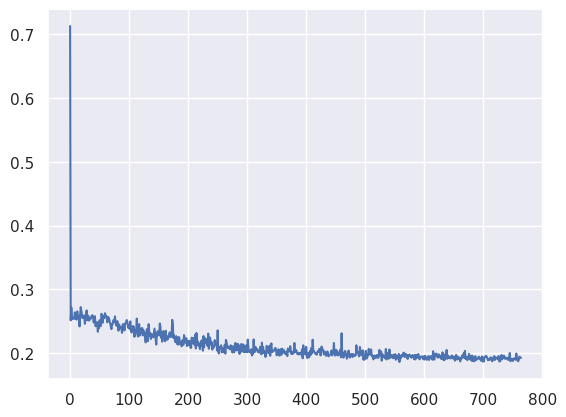

In [323]:
plt.plot(g_rcon_loss)

In [324]:

noise_gens = noise_gens.to(device)

gens = gens.to(device)
z_sample = GQ(noise_gens)
X_sample = GP(z_sample)

#print(z_sample)
#print(X_sample)

#encoded latent space
print(len(z_sample)) #batch size
print(len(z_sample[0])) #latent dimensions space

#decoder
print(len(X_sample)) #batch size
print(len(X_sample[0])) #num loci * alleles

10
10000
10
8594


In [325]:
X_sample
len(X_sample[0])

8594

In [326]:
pred_gg = pd.DataFrame(X_sample.cpu().detach().numpy().T)
pred_gg

gens = gens.cpu()

In [327]:
pred_gg["samp1_rounded"] = (pred_gg[0] / 1).round()
pred_gg["samp2_rounded"] = (pred_gg[1] / 1).round()
pred_gg["samp3_rounded"] = (pred_gg[2] / 1).round()
pred_gg["samp4_rounded"] = (pred_gg[3] / 1).round()

pred_gg

contingency_table = pd.crosstab(pred_gg["samp1_rounded"], gens[0])
print('\n',contingency_table)

contingency_table = pd.crosstab(pred_gg["samp2_rounded"], gens[1])
print('\n',contingency_table)


contingency_table = pd.crosstab(pred_gg["samp3_rounded"], gens[2])
print('\n',contingency_table)


contingency_table = pd.crosstab(pred_gg["samp4_rounded"], gens[3])
print('\n',contingency_table)



 col_0           0.0   1.0
samp1_rounded            
0.0            3967   332
1.0             330  3965

 col_0           0.0   1.0
samp2_rounded            
0.0            4002   298
1.0             295  3999

 col_0           0.0   1.0
samp3_rounded            
0.0            3967   327
1.0             330  3970

 col_0           0.0   1.0
samp4_rounded            
0.0            3975   323
1.0             322  3974


Evaluate g-g on decoder

In [328]:

# test the g-g prediction
gen_encodings = []
phens = []
gen_latent = []
gen_original = []


GQ.eval()
GP.eval()

for dat in test_loader_geno:
    gt = dat
    gt = gt[:, : n_geno * n_alleles]
    gt = gt.to(device)
    batch_size = 10
    z_sample = GQ(gt)
    X_sample = GP(z_sample)
    gen_encodings += list(X_sample.detach().cpu().numpy())
    gen_latent += list(z_sample.detach().cpu().numpy())
    gen_original += list(gt.detach().cpu().numpy())


[0.6893354654312134, 0.7041751146316528, 0.7044485807418823, 0.7068098783493042, 0.7125120162963867, 0.712568998336792, 0.7109320163726807, 0.7030246257781982, 0.7143468856811523, 0.6938628554344177, 0.7153129577636719, 0.6966519355773926, 0.7009859085083008, 0.6961252689361572, 0.6880440711975098, 0.6892572641372681, 0.6943916082382202, 0.7321617603302002, 0.7038589715957642, 0.725723147392273, 0.6937704682350159, 0.6944564580917358, 0.6955136060714722, 0.6890099048614502, 0.7167521715164185, 0.6944246292114258, 0.7008550763130188, 0.7112128138542175, 0.702383279800415, 0.7074693441390991, 0.6799152493476868, 0.7068790197372437, 0.6876492500305176, 0.716762363910675, 0.6920126676559448, 0.7086954116821289, 0.7069584131240845, 0.6994659900665283, 0.7044905424118042, 0.7125236988067627, 0.720482587814331, 0.6800218820571899, 0.7102617025375366, 0.6937788724899292, 0.7092541456222534, 0.722159206867218, 0.7106403112411499, 0.6994044780731201, 0.6937448978424072, 0.7090048789978027, 0.717

(array([  7.,  17.,  58.,  82., 109.,  91.,  51.,  25.,   4.,   6.]),
 array([0.66617745, 0.67435231, 0.68252716, 0.69070202, 0.69887687,
        0.70705172, 0.71522658, 0.72340143, 0.73157629, 0.73975114,
        0.747926  ]),
 <BarContainer object of 10 artists>)

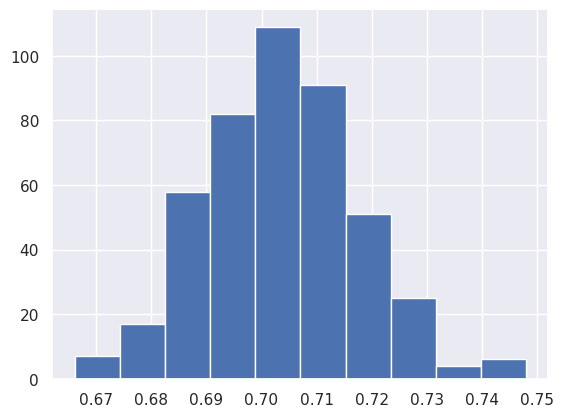

In [329]:
errs = [r2_score(gen_encodings[n], gen_original[n]) for n in range(len(gen_original[:len(gen_original)]))]
print(errs)
plt.hist(errs)

In [330]:
import pandas as pd


errsdf = pd.DataFrame(errs)
errsdf["latent_space_size"] = latent_space_g
errsdf["epochs"] = num_epochs_gen
errsdf


#errsdf.to_csv('test_err_output.csv',  sep=',')

,0,latent_space_size,epochs
0,0.689335,10000,3
1,0.704175,10000,3
2,0.704449,10000,3
3,0.706810,10000,3
4,0.712512,10000,3
...,...,...,...
445,0.701026,10000,3
446,0.720633,10000,3
447,0.680906,10000,3
448,0.706781,10000,3


In [331]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

full_data_geno = dataset_geno('../LTEE_presence_absence.pk', n_geno=n_geno )


full_loader_geno = torch.utils.data.DataLoader(
    dataset=full_data_geno, batch_size=10, num_workers=1, shuffle=True
)

FileNotFoundError: [Errno 2] No such file or directory: '../LTEE_presence_absence.pk'

In [ ]:

# visualise the g-g prediction on full dataset
gen_encodings = []
phens = []
gen_latent = []
gen_original = []


GQ.eval()
GP.eval()

for dat in full_loader_geno:
    gt = dat
    gt = gt[:, : 97323]
    gt = gt.to(device)
    batch_size = 10
    z_sample = GQ(gt)
    X_sample = GP(z_sample)
    gen_encodings += list(X_sample.detach().cpu().numpy())
    gen_latent += list(z_sample.detach().cpu().numpy())
    gen_original += list(gt.detach().cpu().numpy())

In [ ]:
metadata_df = pd.read_csv('../LTEE_subset_metadata_test.txt', sep="\t")

latent_df = pd.DataFrame(gen_latent)
latent_df

pca = PCA(n_components=3)
pca_result = pca.fit_transform(latent_df.values)
pca_result_df = pd.DataFrame(pca_result)
pca_result_df

,0,1,2
0,9.135866,-5.798387,5.612400
1,12.245443,10.315765,2.014167
2,9.614843,4.982611,0.264684
3,-12.967310,-1.703812,-0.135181
4,0.522425,1.262440,-5.865958
...,...,...,...
7038,-12.014120,-2.968994,0.568472
7039,9.889732,-1.778823,1.328138
7040,-10.694343,3.945276,0.635330
7041,9.071611,-0.440149,-11.243353


<Axes: xlabel='0', ylabel='1'>

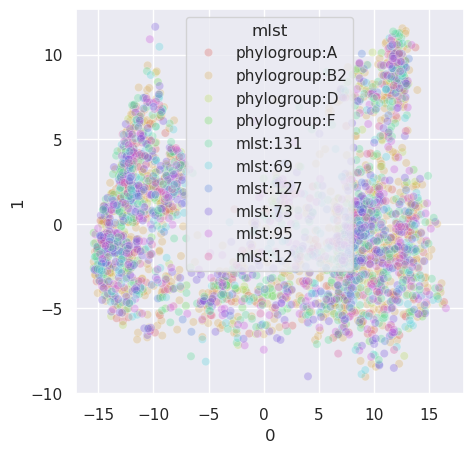

In [ ]:
plt.figure(figsize=(5,5))
sns.scatterplot(
    x=pca_result_df[0], y=pca_result_df[1],
    palette=sns.color_palette("hls", 10),
    hue=metadata_df['mlst'],
    data=pca_result_df,
    legend="full",
    alpha=0.3
)

In [ ]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(latent_df)
tsne_results_df = pd.DataFrame(tsne_results)
tsne_results_df

/home/ubuntu/miniforge3/envs/gpatlas/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 7043 samples in 0.009s...
[t-SNE] Computed neighbors for 7043 samples in 0.350s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7043
[t-SNE] Computed conditional probabilities for sample 2000 / 7043
[t-SNE] Computed conditional probabilities for sample 3000 / 7043
[t-SNE] Computed conditional probabilities for sample 4000 / 7043
[t-SNE] Computed conditional probabilities for sample 5000 / 7043
[t-SNE] Computed conditional probabilities for sample 6000 / 7043
[t-SNE] Computed conditional probabilities for sample 7000 / 7043
[t-SNE] Computed conditional probabilities for sample 7043 / 7043
[t-SNE] Mean sigma: 2.945390
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.607128
[t-SNE] KL divergence after 300 iterations: 1.791835


,0,1
0,4.944102,-6.949964
1,-0.561325,10.871067
2,10.375750,5.323092
3,-4.922244,0.285041
4,-0.056022,6.366682
...,...,...
7038,-4.397260,-4.506930
7039,10.854112,-1.612836
7040,-2.617870,7.591592
7041,3.605064,1.626123


<Axes: xlabel='0', ylabel='1'>

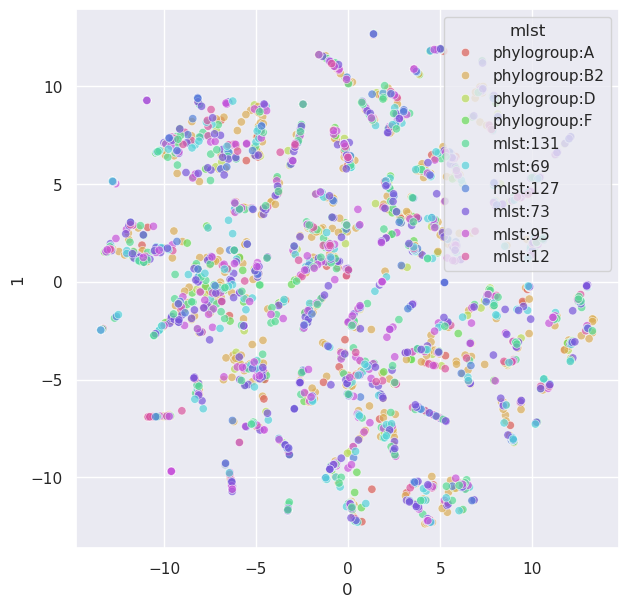

In [ ]:
plt.figure(figsize=(7,7))

sns.scatterplot(
    x=tsne_results_df[0], y=tsne_results_df[1],
    palette=sns.color_palette("hls", 10),
    hue=metadata_df['mlst'],
    data=tsne_results_df,
    legend="full",
    alpha=0.7
)